# Evaluate Batch Removal Performance


***Created on 04/24/2023***

***@author: jane***


This notebook reproduces our "hold-one-contorl-out" experiment. We apply iLISI and UMAP visualization to evaluated batch removal performance of the method. The data we use for this tutorial is from a type 1 diabetes by [***Maria Fasolino et al. (2022)***](https://www.nature.com/articles/s42255-022-00531-x), and it can be downloaded from [here](https://cellxgene.cziscience.com/collections/51544e44-293b-4c2b-8c26-560678423380). We have subsampled 20,000 cells for illustration purposes.

In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import harmonypy as hm
import scanpy.external as sce

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80)
pd.set_option('display.max_columns', None)
seed = 10
np.random.seed(seed)

The idea of the "hold-one-contorl-out" experiment is as follows. 
- For each data set, we hold out one of the $m_0$ samples in the original control-pool and apply CellANOVA with the control-pool limited to the remaining $m_0-1$ samples.  
- Then, we examine whether the held-out control sample is effectively integrated with the other control-pool samples.  

Ideally, the held-out control sample should be well-integrated with the other control-pool samples, even if it were not used in the estimation of the batch-basis matrix. 

This hold-out analysis can be viewed as a robustness test:  For CellANOVA to be effective in removing batch effects from  samples outside the control pool, the control-pool needs to exhibit the diversity of batch variations that affect all samples.  If the held-out sample were not well-mixed with the other control-pool samples post-integration,  then we would doubt that the batch-basis matrix estimated from the control-pool captures all of the unwanted variation in the study.   

## 1. Load data, preprocess

Now we load data and we only take control samples from this dataset to perform experiment. We use `cnova.model.preprocess_data` to perform preprocessing.

In [2]:
adata = sc.read_h5ad('t1d_example.h5ad')
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[adata.obs['PseudoState']=='Control',]

In [3]:
adata_prep = cnova.model.preprocess_data(adata, integrate_key='dataidx')

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 2. Control pool construction

We have a total of 11 control samples. All of these patients are healthy ones.

In [4]:
np.unique(adata_prep.obs['dataidx'])

array(['HPAP022', 'HPAP026', 'HPAP034', 'HPAP035', 'HPAP036', 'HPAP037',
       'HPAP039', 'HPAP040', 'HPAP042', 'HPAP044', 'HPAP047'],
      dtype=object)

We pretend that we don't know sample 'HPAP035' is healthy. Instead, suppose we received wrong information, that this sample is a diseased one. Then following our pipeline, our control pool will only have 10 patients. We construct control pool as follows.

In [5]:
adata_prep.obs['PseudoState'] = pd.Categorical(adata_prep.obs['PseudoState'], 
                                                categories=['Control', 'Fake Disease'])
adata_prep.obs.loc[adata_prep.obs['dataidx']=='HPAP035','PseudoState'] = "Fake Disease"

In [6]:
pd.crosstab(adata_prep.obs['PseudoState'], adata_prep.obs['dataidx'])

dataidx,HPAP022,HPAP026,HPAP034,HPAP035,HPAP036,HPAP037,HPAP039,HPAP040,HPAP042,HPAP044,HPAP047
PseudoState,,,,,,,,,,,
Control,989,152,113,0,539,1076,1159,605,907,817,689
Fake Disease,0,0,0,585,0,0,0,0,0,0,0


In the control pool (`control_dict`), there is one control group denoted by `'g1'`. And values in this group are the `'dataidx'` of known control samples (excluding the fake treatment one 'HPAP035').

In [7]:
integrate_key = 'dataidx'
condition_key = 'PseudoState'
control_name = 'Control'
control_batches = list(set(adata_prep[adata_prep.obs[condition_key]==control_name,].obs[integrate_key]))
control_dict = {
    'g1': control_batches,
}
control_dict

{'g1': ['HPAP036',
  'HPAP022',
  'HPAP039',
  'HPAP026',
  'HPAP037',
  'HPAP034',
  'HPAP044',
  'HPAP047',
  'HPAP040',
  'HPAP042']}

## 2. CellANOVA integration

Now we follow the standard CellANOVA pipeline, using control samples to estimate batch variation basis then project out batch effect for both samples from control pool and the heldout fake disease sample.

In [8]:
adata_prep= cnova.model.calc_ME(adata_prep, integrate_key='dataidx')
adata_prep = cnova.model.calc_BE(adata_prep, integrate_key, control_dict)
adata_prep = cnova.model.calc_TE(adata_prep, integrate_key)

2023-04-24 10:25:36,867 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-24 10:25:39,194 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-24 10:25:39,226 - harmonypy - INFO - Iteration 1 of 30
2023-04-24 10:25:40,957 - harmonypy - INFO - Iteration 2 of 30
2023-04-24 10:25:42,759 - harmonypy - INFO - Iteration 3 of 30
2023-04-24 10:25:44,576 - harmonypy - INFO - Iteration 4 of 30
2023-04-24 10:25:46,540 - harmonypy - INFO - Iteration 5 of 30
2023-04-24 10:25:47,863 - harmonypy - INFO - Iteration 6 of 30
2023-04-24 10:25:48,894 - harmonypy - INFO - Iteration 7 of 30
2023-04-24 10:25:50,120 - harmonypy - INFO - Iteration 8 of 30
2023-04-24 10:25:52,004 - harmonypy - INFO - Iteration 9 of 30
2023-04-24 10:25:53,663 - harmonypy - INFO - Iteration 10 of 30
2023-04-24 10:25:55,635 - harmonypy - INFO - Iteration 11 of 30
2023-04-24 10:25:56,552 - harmonypy - INFO - Iteration 12 of 30
2023-04-24 10:25:57,476 - harmonypy - INFO - Iteration 13 of

## 3. UMAP visualization

To assess the efficacy of the batch correction, we employed UMAP to visualize the distribution of the fake disease sample (heldout one) in relation to the control samples after batch correction. Since our validation experiments only included control samples from without any treatment signals, we anticipate the fake treatment sample to be adequately mixed with the control samples if the batch correction method is ideal.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


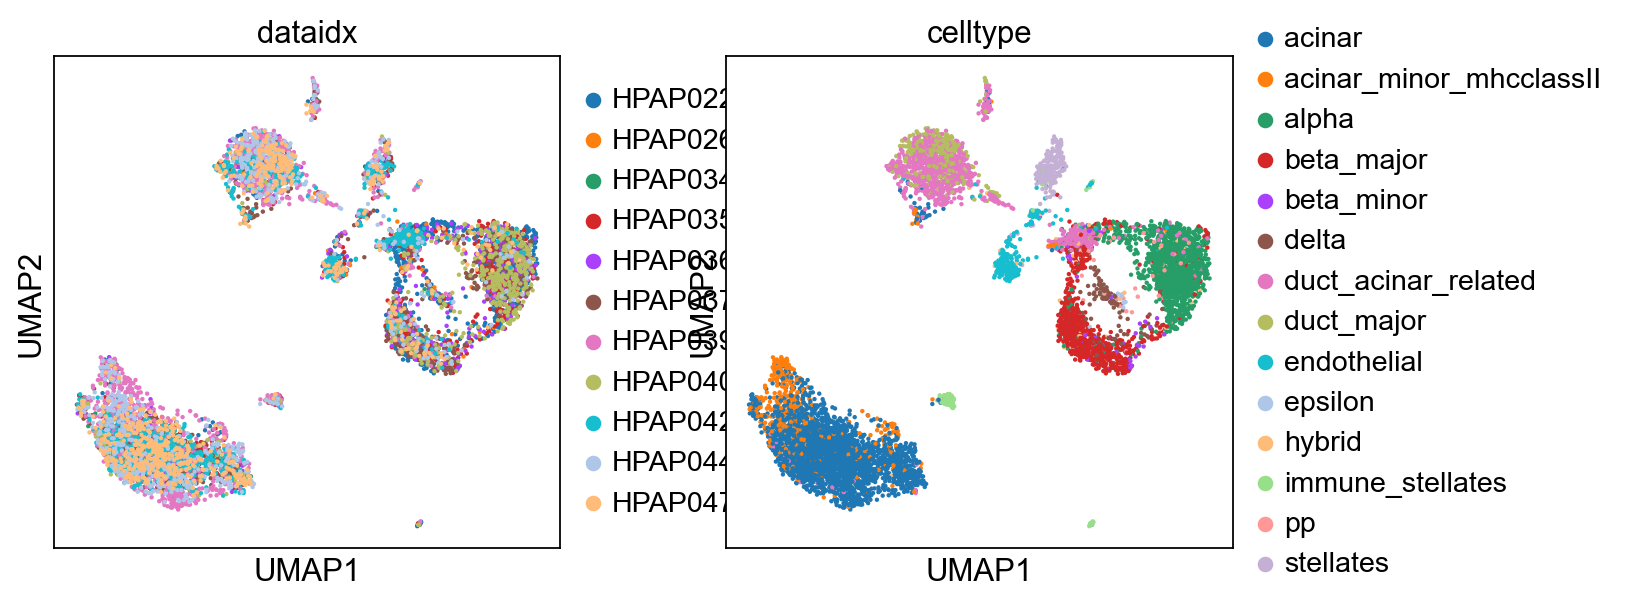

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


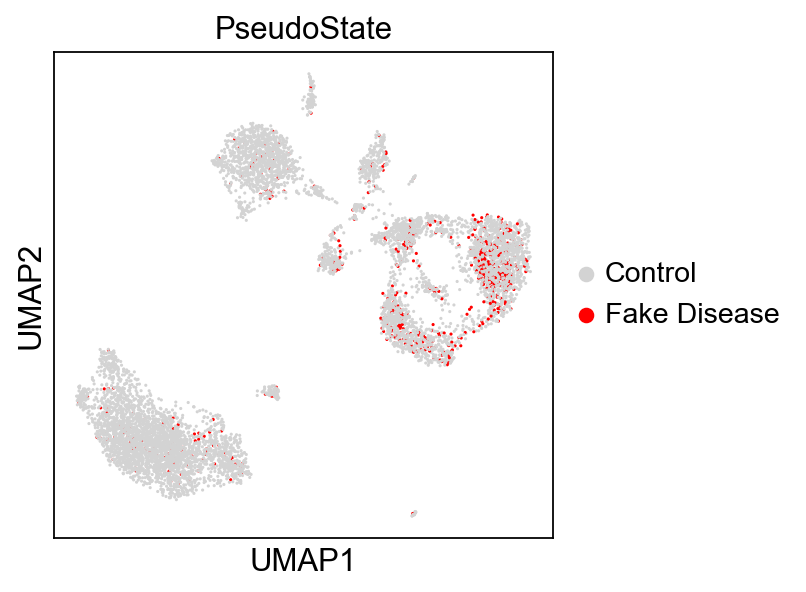

In [9]:
integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
integrated.obs = adata_prep.obs.copy()
integrated.var_names = adata_prep.var_names
sc.pp.neighbors(integrated, n_neighbors=15, n_pcs=30)
sc.tl.umap(integrated)
sc.pl.umap(integrated, color=['dataidx', 'celltype'])
integrated.uns['PseudoState_colors'] = ["#D3D3D3","red"]
integrated.obs['PseudoState'] = integrated.obs['PseudoState'].cat.reorder_categories(['Control','Fake Disease'])
sc.pl.umap(integrated, color=['PseudoState'], groups=['Control','Fake Disease'], size=8)

From the UMAP, we can see that although we only use samples from control pool to **estimate** batch effect, we can still successfully **remove** batch effect for the holdout sample.

On the other hand, although we treat the holdout "Fake Desease" sample as a true disease model during model fitting, the final integration result tells us this sample is similar to other control samples, because Control and Fake Disease after batch correction are mapped together. In other words, our method is robust to false prior information. **No false treatment effects are detected, although false information is provided to the model.**

## 4. Compute iLISI

We also used local inverse Simpson’s index with respect to batch labels (iLISI) proposed by [Ilya Korsunsky et al. (2019)](https://www.nature.com/articles/s41592-019-0619-0), as our metric to measure batch mixing. It defines the effective number of batches after scaling in the neighborhood of a cell, and a higher iLISI value indicates more uniform batch mixing. We use function `compute_lisi` provided by Python package `harmonypy` to compute iLISI.

In [10]:
data_mat1 = sc.tl.pca(integrated.X, n_comps = 15)
result = hm.compute_lisi(data_mat1, 
                         integrated.obs[['dataidx', 'celltype', 'PseudoState']],
                         ['dataidx', 'celltype', 'PseudoState'])
res = pd.DataFrame(result,
                   index = integrated.obs_names,
                   columns = ['LISI_dataidx', 'LISI_celltype', 'LISI_PseudoState'])

res['labels_dataidx'] = integrated.obs.loc[res.index, 'dataidx']
res['labels_celltype'] = integrated.obs.loc[res.index, 'celltype']
res['labels_PseudoState'] = integrated.obs.loc[res.index, 'PseudoState']

The following shows the iLISI for cells from both control and fake disease samples:

<Axes: xlabel='LISI_dataidx'>

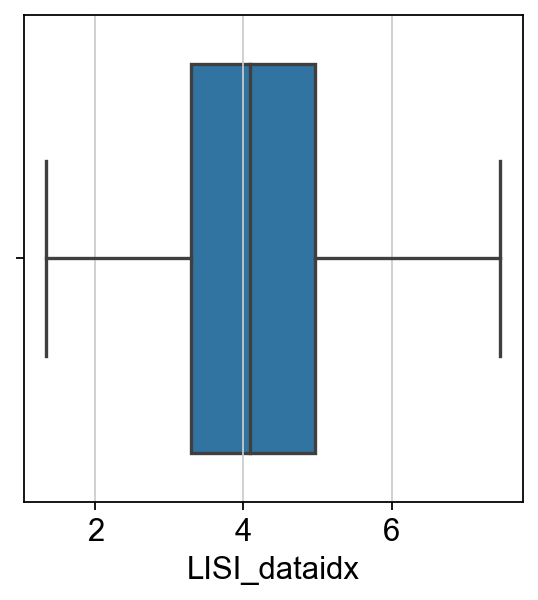

In [11]:
sea.boxplot(data=res, x="LISI_dataidx", showfliers = False)

The following shows the iLISI for cells from only fake disease samples:

<Axes: xlabel='LISI_dataidx'>

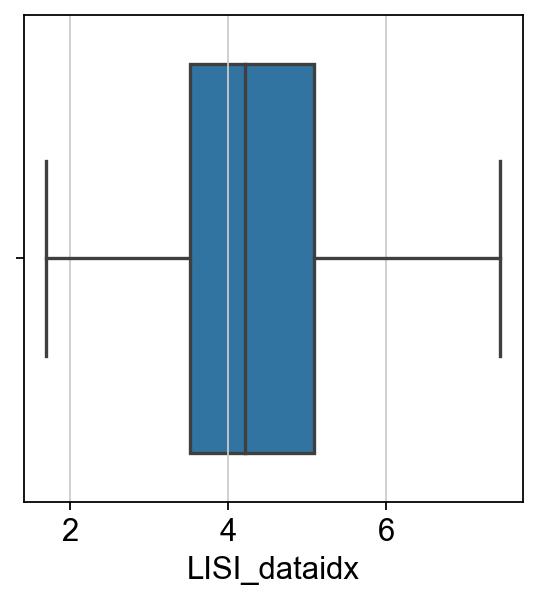

In [12]:
sea.boxplot(data=res[res['labels_PseudoState']=='Fake Disease'], 
            x="LISI_dataidx", showfliers = False)

## 5. Compare with harmony

The following is a simple version of harmony intergration. We use the python implementation of harmony, from package `harmonypy`. One can also use their own code for other methods.

In [13]:
rna_temp = ad.AnnData(adata_prep.layers['scale'], dtype = np.float32)
rna_temp.var_names = adata_prep.var_names
rna_temp.obs = adata_prep.obs.copy()
sc.tl.pca(rna_temp)
sce.pp.harmony_integrate(rna_temp, 'dataidx')
harmony = ad.AnnData(rna_temp.obsm['X_pca_harmony'] @ rna_temp.varm['PCs'].T, dtype = np.float32)
harmony.var_names = rna_temp.var_names
harmony.obs = rna_temp.obs.copy()

2023-04-24 10:27:07,124 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-24 10:27:10,418 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-24 10:27:10,452 - harmonypy - INFO - Iteration 1 of 10
2023-04-24 10:27:12,173 - harmonypy - INFO - Iteration 2 of 10
2023-04-24 10:27:14,082 - harmonypy - INFO - Iteration 3 of 10
2023-04-24 10:27:15,695 - harmonypy - INFO - Iteration 4 of 10
2023-04-24 10:27:17,444 - harmonypy - INFO - Iteration 5 of 10
2023-04-24 10:27:18,873 - harmonypy - INFO - Iteration 6 of 10
2023-04-24 10:27:19,926 - harmonypy - INFO - Iteration 7 of 10
2023-04-24 10:27:21,289 - harmonypy - INFO - Iteration 8 of 10
2023-04-24 10:27:22,523 - harmonypy - INFO - Iteration 9 of 10
2023-04-24 10:27:24,230 - harmonypy - INFO - Iteration 10 of 10
2023-04-24 10:27:26,043 - harmonypy - INFO - Stopped before convergence


UMAP visualization using harmony-correceted data is as follows.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


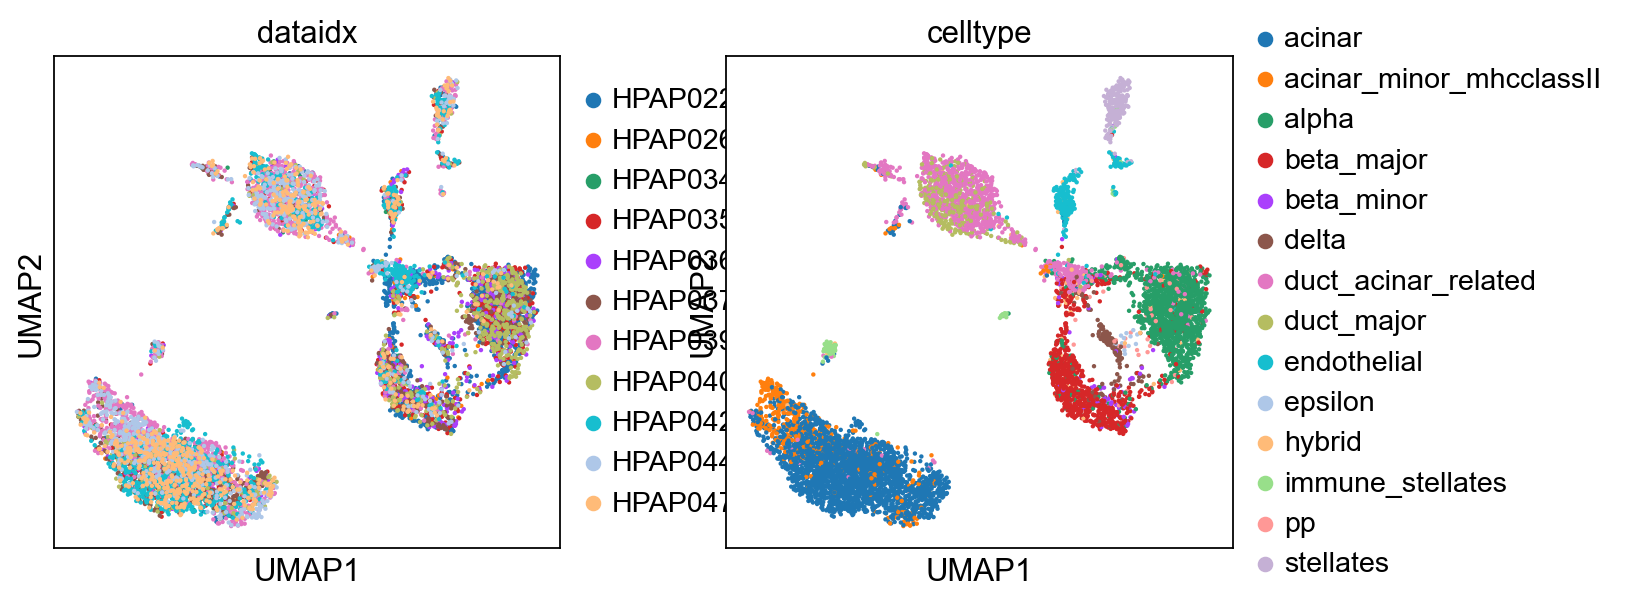

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


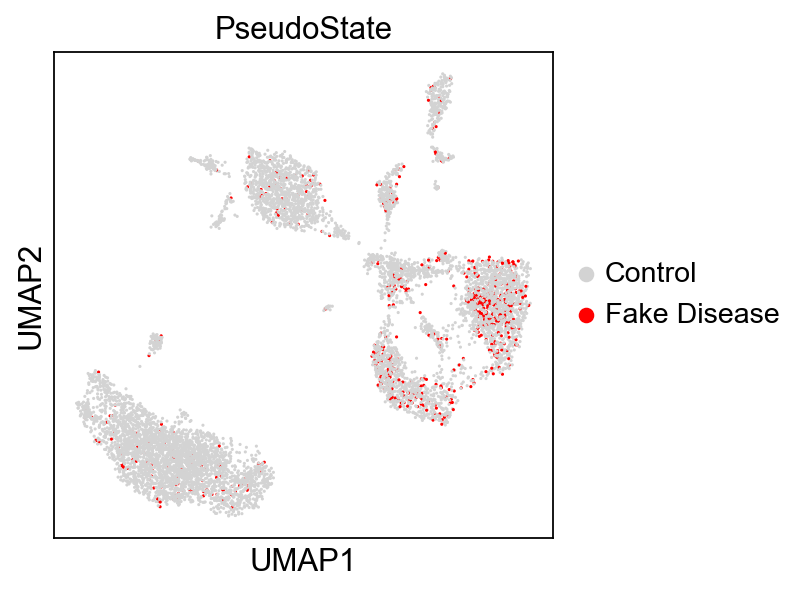

In [14]:
sc.pp.neighbors(harmony, n_neighbors=15, n_pcs=30)
sc.tl.umap(harmony)
sc.pl.umap(harmony, color=['dataidx', 'celltype'])
harmony.uns['PseudoState_colors'] = ["#D3D3D3","red"]
harmony.obs['PseudoState'] = harmony.obs['PseudoState'].cat.reorder_categories(['Control','Fake Disease'])
sc.pl.umap(harmony, color=['PseudoState'], groups=['Control','Fake Disease'], size=8)

We compute iLISI for harmony as we did for CellANOVA, and compare iLISI. The higher this value indicates the better batch mixing.

<Axes: xlabel='LISI_dataidx', ylabel='Method'>

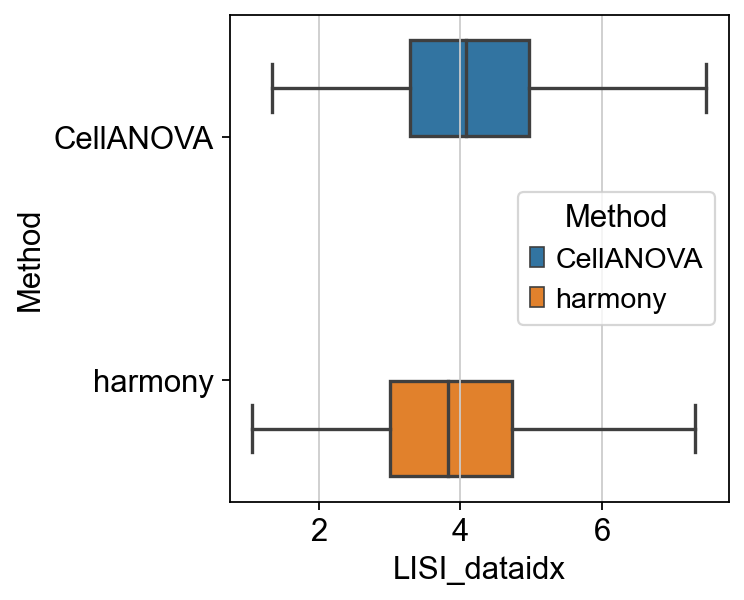

In [15]:
data_mat2 = sc.tl.pca(harmony.X, n_comps = 15)
result2 = hm.compute_lisi(data_mat2, 
                         harmony.obs[['dataidx', 'celltype', 'PseudoState']],
                         ['dataidx', 'celltype', 'PseudoState'])
res2 = pd.DataFrame(result2,
                    index = harmony.obs_names,
                    columns = ['LISI_dataidx', 'LISI_celltype', 'LISI_PseudoState'])

res2['labels_dataidx'] = harmony.obs.loc[res.index, 'dataidx']
res2['labels_celltype'] = harmony.obs.loc[res.index, 'celltype']
res2['labels_PseudoState'] = harmony.obs.loc[res.index, 'PseudoState']

res2['Method'] = 'harmony'
res['Method'] = 'CellANOVA'
df = pd.concat([res, res2], ignore_index=True, sort = False)
sea.boxplot(data=df, 
            x="LISI_dataidx", y="Method", 
            hue="Method", showfliers = False)